<a href="https://colab.research.google.com/github/yerimming/gachon/blob/main/CV_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip3 install adamp

  Preparing metadata (setup.py) ... done
  Created wheel for adamp: filename=adamp-0.3.0-py3-none-any.whl size=5981 sha256=8e8a4777db2c16aca7c84d912209a21707ec1be204a251d94c4b05f84487561a
  Stored in directory: /root/.cache/pip/wheels/c7/ad/0f/b41b1c45b18c66e5eef5d2254415af8055c7e2b0934145157d
Successfully built adamp


In [3]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor,Normalize, RandomHorizontalFlip, Resize
from torchvision.transforms import RandAugment
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image,ImageFilter,ImageEnhance

from torch.utils.data import ConcatDataset
from collections import Counter

from adamp import AdamP

# 스케줄러 사용
from torch.optim.lr_scheduler import CosineAnnealingLR

import re

# 랜덤 시드 설정 공통
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


In [4]:
### Custom Dataset ###
class CUB2011(Dataset):
  def __init__(self, transform, mode='train'):
    self.transform = transform
    self.mode = mode

    if self.mode == 'train':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/CUB_200_2011_repackage_class50/datasets/train')
    elif self.mode == 'valid':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/CUB_200_2011_repackage_class50/datasets/valid')
    elif self.mode == 'test':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/CUB_200_2011_repackage_class50/datasets/test')

  def __len__(self):
    return len(self.image_folder)

  def __getitem__(self, idx):
    img_path = self.image_folder[idx]
    img = Image.open(os.path.join('/content/gdrive/MyDrive/CUB_200_2011_repackage_class50/datasets', self.mode, img_path)).convert('RGB')
    img = self.transform(img)
    label = img_path.split('_')[-1].split('.')[0]
    label = re.sub(r'\([^)]*\)', '', label)
    label = int(label)
    return (img, label)

In [5]:
### Data Preprocessing ###
transforms_train_origin = transforms.Compose([transforms.Resize((448,448)),
                                       transforms.ToTensor()])
transforms_test = transforms.Compose([transforms.Resize((448,448)),
                                       transforms.ToTensor()])

# Apply RandAugment
transforms_train_rand = transforms.Compose([
    transforms.Resize((448, 448)),
    RandAugment(5,3),
    transforms.ToTensor()])

BATCH_SIZE = 32

train_set_origin = CUB2011(mode='train',
                    transform=transforms_train_origin)
val_set = CUB2011(mode='valid',
                  transform=transforms_test)
test_set = CUB2011(mode='test',
                  transform=transforms_test)

# 데이터 증강을 위해 원래 데이터를 복사하고 추가
train_set_augmented = CUB2011(mode='train', transform=transforms_train_rand)

# 두 데이터셋을 연결하여 새로운 훈련 데이터셋 생성
train_set_combined = ConcatDataset([train_set_origin, train_set_augmented])

print('Num of each dataset: ',len(train_set_origin),len(train_set_augmented))
print('Num of each dataset: ',len(train_set_combined),len(val_set),len(test_set))

train_loader = DataLoader(train_set_combined, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=False)
test_loader = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=False)

print("Loaded dataloader")

Num of each dataset:  2362 2362
Num of each dataset:  4724 296 298
Loaded dataloader


Batch 1


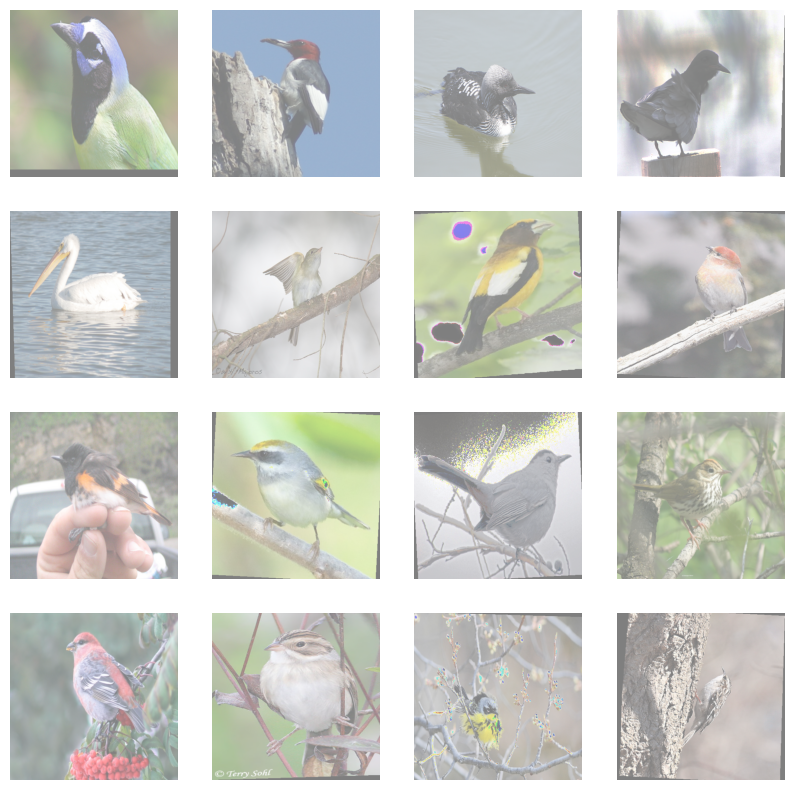

Batch 2


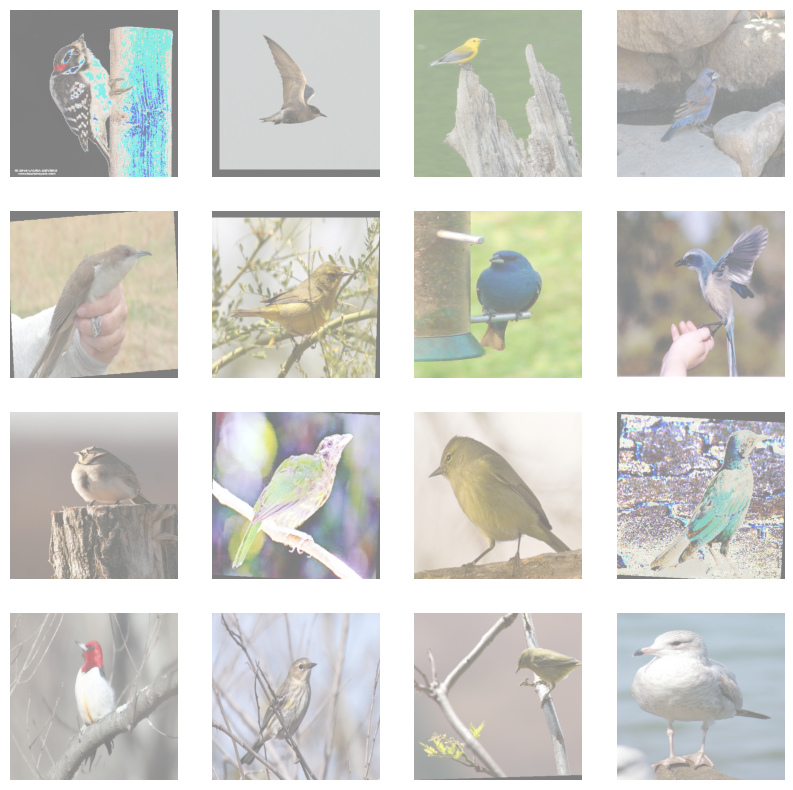

Batch 3


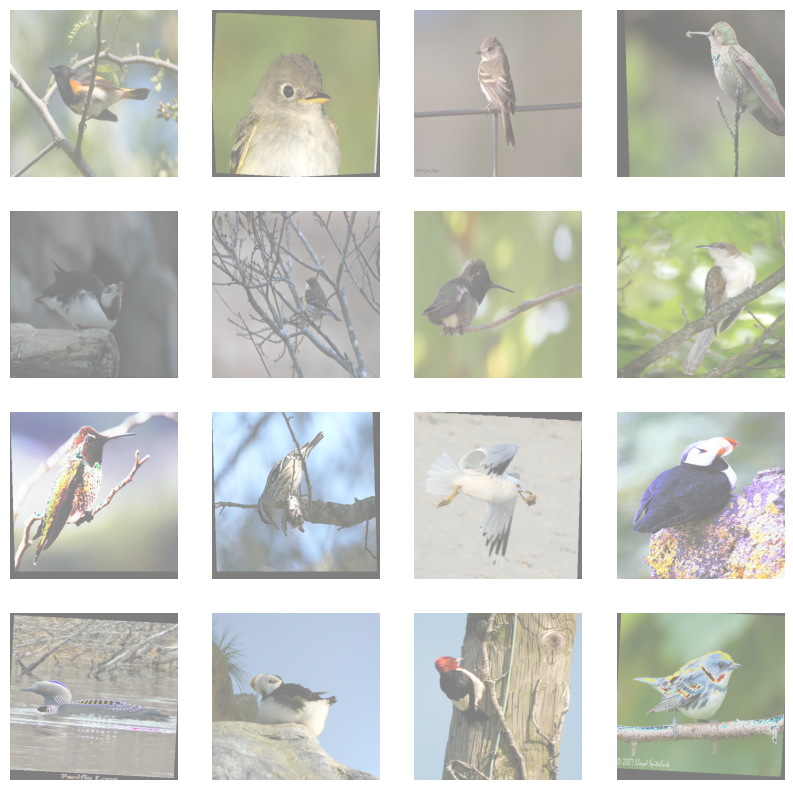

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of rows and columns for the grid
num_rows = 4  # You can change this to the desired number of rows
num_cols = 4  # You can change this to the desired number of columns

# Function to unnormalize and display a grid of images
def imshow_grid(images, num_rows, num_cols):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < len(images):
                img = images[index] / 2 + 0.5  # Unnormalize the image
                npimg = img.numpy()
                ax = axes[i, j]
                ax.imshow(np.transpose(npimg, (1, 2, 0)))
                ax.axis('off')

    plt.show()

# Iterate through the train_loader
for batch_idx, (images, labels) in enumerate(train_loader):
    if batch_idx >= 3:
        break  # Stop after visualizing the specified number of batches

    print(f"Batch {batch_idx + 1}")
    imshow_grid(images, num_rows, num_cols)  # Display the grid of images

In [7]:
### Model / Optimizer ###
EPOCH = 30
lr = 0.0001

model = models.resnet18(pretrained=True)

### Tranfer Learning ###
num_features = model.fc.in_features
model.fc = nn.Linear(num_features,50)
model.to(DEVICE)

optimizer = AdamP(model.parameters(),lr=lr)

# 스케줄러 초기화 (주기와 최소/최대 학습률 설정)
dataset_size = len(train_set_combined)  # 훈련 데이터셋 크기

T_max = dataset_size / BATCH_SIZE  # 한 주기의 에폭 수
scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=0.001)

print("Created a learning model and optimizer")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 82.8MB/s]


Created a learning model and optimizer


In [8]:
### Train/Evaluation ###
def train(model,train_loader,optimizer,epoch):
  model.train()
  for i,(image,target) in enumerate(train_loader):
    image,target = image.to(DEVICE),target.to(DEVICE)
    output = model(image)
    optimizer.zero_grad()
    # loss func을 어떤 것을 사용할 것인지?
    train_loss = F.cross_entropy(output,target).to(DEVICE)

    train_loss.backward()
    optimizer.step()

    # 스케줄러 업데이트
    scheduler.step()

    if i%10 ==0:
      print(
          f'Train Epoch: {epoch} [{i}/{len(train_loader)}]\tloss: {train_loss.item():6f}')

  return train_loss

def evaluate(model,val_loader):
  model.eval()
  eval_loss = 0
  correct = 0
  with torch.no_grad():
    for i,(image,target) in enumerate(val_loader):
      image,target = image.to(DEVICE),target.to(DEVICE)
      output = model(image)

      eval_loss += F.cross_entropy(output,target, reduction='sum').item()
      pred = output.max(1,keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

  eval_loss /= len(val_loader.dataset)
  eval_accuracy = 100*correct / len(val_loader.dataset)
  return eval_loss,eval_accuracy

In [9]:
### Main ###
start = time.time()
best = 0
for epoch in range(EPOCH):
  train_loss = train(model,train_loader,optimizer,epoch)
  val_loss,val_accuracy = evaluate(model,val_loader)

  # Save best model
  if val_accuracy > best:
    best = val_accuracy
    torch.save(model.state_dict(),"./best_model.pth")

  print(f"[{epoch}]Validation Loss: {val_loss:.4f},Accuracy: {val_accuracy:.4f}%")

# Test result
test_loss,test_accuracy = evaluate(model,test_loader)
print(f'[FINAL] Test Loss: {test_loss:.4f},Accuracy: {test_accuracy:.4f}%')

end = time.time()
elasped_time = end - start

print("Best Accuracy: ",best)
print(
    f"Elasped Time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")
print(
    f"time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")

Train Epoch: 0 [0/148]	loss: 4.157953
Train Epoch: 0 [10/148]	loss: 3.929232
Train Epoch: 0 [20/148]	loss: 3.450285
Train Epoch: 0 [30/148]	loss: 3.175003
Train Epoch: 0 [40/148]	loss: 2.713577
Train Epoch: 0 [50/148]	loss: 2.576429
Train Epoch: 0 [60/148]	loss: 2.050758
Train Epoch: 0 [70/148]	loss: 1.979164
Train Epoch: 0 [80/148]	loss: 1.684508
Train Epoch: 0 [90/148]	loss: 1.548824
Train Epoch: 0 [100/148]	loss: 1.498897
Train Epoch: 0 [110/148]	loss: 1.337805
Train Epoch: 0 [120/148]	loss: 1.472683
Train Epoch: 0 [130/148]	loss: 1.297601
Train Epoch: 0 [140/148]	loss: 1.338110
[0]Validation Loss: 2.3113,Accuracy: 42.5676%
Train Epoch: 1 [0/148]	loss: 1.069635
Train Epoch: 1 [10/148]	loss: 1.317129
Train Epoch: 1 [20/148]	loss: 0.872800
Train Epoch: 1 [30/148]	loss: 0.935453
Train Epoch: 1 [40/148]	loss: 0.790926
Train Epoch: 1 [50/148]	loss: 0.927080
Train Epoch: 1 [60/148]	loss: 0.781486
Train Epoch: 1 [70/148]	loss: 0.455013
Train Epoch: 1 [80/148]	loss: 0.645895
Train Epoch: 1 

In [10]:
# 이제 손실 값을 플로팅합니다.
import matplotlib.pyplot as plt

# train_loss와 val_loss 텐서를 CPU로 이동하고 NumPy 배열로 변환
train_losses = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses = [loss.
              cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), train_losses, label='train_loss', marker='o')
plt.plot(range(1, EPOCH + 1), val_losses, label='val_loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


val_accuracys = [acc.cpu().detach().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_accuracys]
plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), val_accuracys, label='val_accuracy', marker='o')
plt.title('Validation Accuracy Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

NameError: ignored

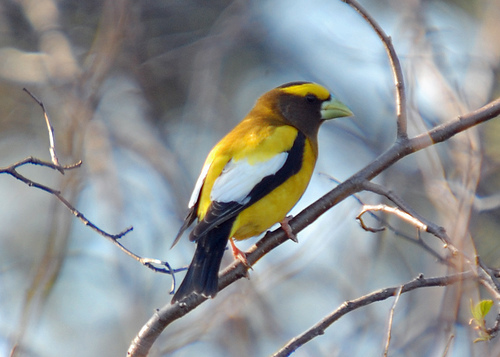

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
import random

# 테스트 데이터셋에서 무작위로 이미지 선택
random_index = random.randint(0, len(test_set) - 1)
img_path = test_set.image_folder[random_index]
img_path = os.path.join('/content/gdrive/MyDrive/CUB_200_2011_repackage_class50/datasets/test', img_path)
display(Image(img_path))

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

35363/35363 [==============================] - 0s 5us/step
Predicted: [('n01531178', 'goldfinch', 6.1390214)]


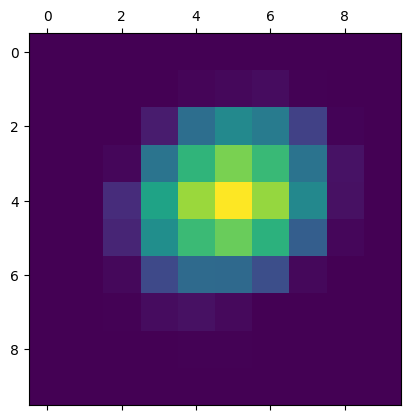

In [15]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

<ipython-input-16-8a3df7f2985d>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


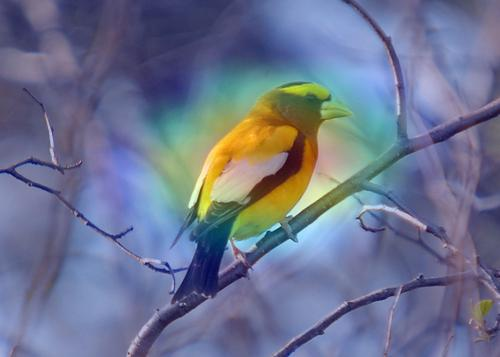

In [16]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)